<a href="https://colab.research.google.com/github/MasDiptha12/Machine-Learning/blob/main/Week_6/Online_Retail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# Langkah 1: Upload file secara manual ke Google Colab
from google.colab import files
uploaded = files.upload()

Saving Online_Retail.xlsx to Online_Retail (7).xlsx


In [24]:
# Langkah 2: Load file Excel yang telah diunggah dan pratinjau 5 baris pertama
import pandas as pd

# Membaca file Excel
df = pd.read_excel(next(iter(uploaded)))

# Menampilkan 5 baris pertama untuk pengecekan
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
# Langkah 3: Pra-pemrosesan data (menghapus data kosong, memilih fitur numerik)
df_clean = df.dropna()

# Misalnya kita ambil fitur numerik yang relevan untuk clustering
# (Anda dapat sesuaikan sesuai konteks dataset Anda)
features = ['Quantity', 'UnitPrice']
df_features = df_clean[features]

# Normalisasi data untuk skala yang seragam
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features)

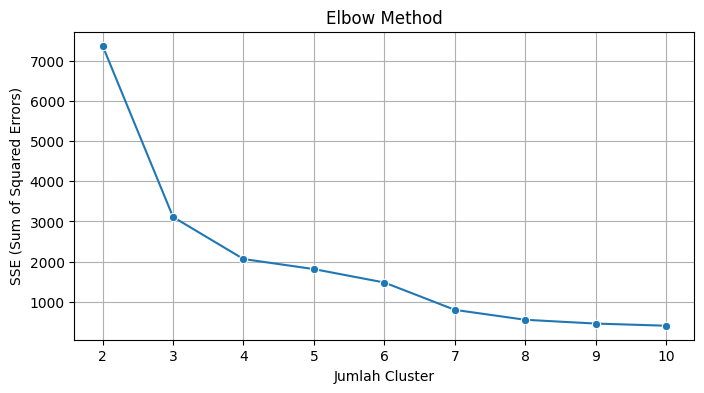

In [26]:
# Langkah 4: Menggunakan Elbow Method untuk menentukan jumlah cluster
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

sse = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

# Visualisasi Elbow Method
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(k_range), y=sse, marker='o')
plt.title('Elbow Method')
plt.xlabel('Jumlah Cluster')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.grid(True)
plt.show()

In [27]:
# Langkah 5: Evaluasi Silhouette, CH Index, DB Index, dan Dunn Index
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import cdist
import numpy as np

def dunn_index(X, labels):
    unique_cluster = np.unique(labels)
    inter_cluster_distances = []
    intra_cluster_distances = []

    for i in unique_cluster:
        cluster_i = X[labels == i]
        intra_dist = np.max(cdist(cluster_i, cluster_i)) if len(cluster_i) > 1 else 0
        intra_cluster_distances.append(intra_dist)
        for j in unique_cluster:
            if i < j:
                cluster_j = X[labels == j]
                inter_dist = np.min(cdist(cluster_i, cluster_j))
                inter_cluster_distances.append(inter_dist)

    return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

# Menyimpan hasil evaluasi untuk berbagai k
results = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    silhouette = silhouette_score(X_scaled, labels)
    ch_index = calinski_harabasz_score(X_scaled, labels)
    db_index = davies_bouldin_score(X_scaled, labels)
    dunn = dunn_index(X_scaled, labels)

    results.append({
        'K': k,
        'Silhouette': silhouette,
        'Calinski-Harabasz': ch_index,
        'Davies-Bouldin': db_index,
        'Dunn': dunn
    })

# Menampilkan hasil evaluasi dalam bentuk DataFrame
results_df = pd.DataFrame(results)
results_df

,K,Silhouette,Calinski-Harabasz,Davies-Bouldin,Dunn
0,2,0.984246,2154.185881,0.297347,0.171792
1,3,0.984535,6114.278178,0.246959,0.602549
2,4,0.707082,7018.372082,0.399118,0.003077
3,5,0.706947,6168.566524,0.235858,0.003219
4,6,0.609880,6282.531395,0.328802,0.001302
5,7,0.621394,10412.657559,0.347283,0.001204
6,8,0.521186,13227.182658,0.352183,0.001351
7,9,0.544899,14071.720091,0.360605,0.002702
8,10,0.545046,14231.056540,0.411432,0.002702


<ipython-input-28-362678180561>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['KMeans_Cluster'] = kmeans_labels
<ipython-input-28-362678180561>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Agg_Cluster'] = agg_labels


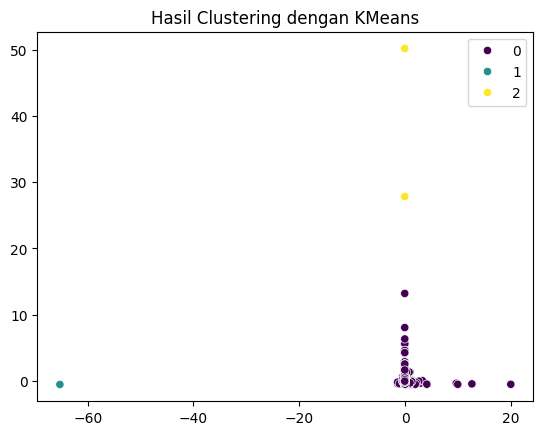

In [28]:
# Langkah 6: Implementasi dua model clustering

from sklearn.cluster import AgglomerativeClustering

# Menggunakan jumlah cluster terbaik, misalnya K=3 (bisa disesuaikan berdasarkan metrik)
best_k = 3

# Model 1: KMeans
kmeans_model = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans_model.fit_predict(X_scaled)

# Model 2: Agglomerative Clustering
agg_model = AgglomerativeClustering(n_clusters=best_k)
agg_labels = agg_model.fit_predict(X_scaled)

# Menambahkan label ke DataFrame
df_clean['KMeans_Cluster'] = kmeans_labels
df_clean['Agg_Cluster'] = agg_labels

# Visualisasi hasil clustering dengan KMeans
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette='viridis')
plt.title('Hasil Clustering dengan KMeans')
plt.show()

In [29]:
# Langkah 7: Menentukan metrik terbaik berdasarkan hasil
# Semakin tinggi Silhouette, CH, Dunn => lebih baik
# Semakin rendah Davies-Bouldin => lebih baik

# Menampilkan hasil untuk nilai terbaik masing-masing metrik
print("Nilai terbaik masing-masing metrik:")
print("Silhouette terbaik pada K =", results_df.loc[results_df['Silhouette'].idxmax(), 'K'])
print("Calinski-Harabasz terbaik pada K =", results_df.loc[results_df['Calinski-Harabasz'].idxmax(), 'K'])
print("Davies-Bouldin terbaik (terendah) pada K =", results_df.loc[results_df['Davies-Bouldin'].idxmin(), 'K'])
print("Dunn Index terbaik pada K =", results_df.loc[results_df['Dunn'].idxmax(), 'K'])

Nilai terbaik masing-masing metrik:
Silhouette terbaik pada K = 3
Calinski-Harabasz terbaik pada K = 10
Davies-Bouldin terbaik (terendah) pada K = 5
Dunn Index terbaik pada K = 3


### Penjelasan Matematis Metrik Evaluasi Clustering

---

#### 1. Silhouette Coefficient

Silhouette Coefficient mengukur seberapa baik suatu titik berada dalam klusternya dibandingkan dengan kluster lain. Nilai berkisar antara -1 hingga 1. Semakin mendekati 1, semakin baik pemisahan antar kluster.

**Rumus:**

s(i) = (b(i) - a(i)) / max(a(i), b(i))

**Keterangan:**
- a(i): Rata-rata jarak antara titik i dan semua titik dalam klusternya.
- b(i): Jarak rata-rata titik i ke titik-titik dalam kluster terdekat selain klusternya sendiri.
- s(i): Nilai silhouette untuk titik i.

---

#### 2. Calinski-Harabasz Index

Indeks ini membandingkan variasi antar-kluster terhadap variasi dalam-kluster. Semakin besar nilainya, semakin baik klusterisasi.

**Rumus:**

CH = (tr(B_k) / tr(W_k)) * ((n - k) / (k - 1))

**Keterangan:**
- tr(B_k): Jejak (trace) matriks antara-kluster (inter-cluster).
- tr(W_k): Jejak (trace) matriks dalam-kluster (intra-cluster).
- n: Jumlah total data.
- k: Jumlah kluster.

---

#### 3. Davies-Bouldin Index

Indeks ini mengukur kesamaan antar kluster. Semakin rendah nilainya, semakin baik kualitas klusterisasi.

**Rumus:**

DB = (1 / k) * Σ_i=1^k [ max_{j ≠ i} ( (σ_i + σ_j) / d(c_i, c_j) ) ]

**Keterangan:**
- k: Jumlah kluster.
- σ_i: Rata-rata jarak antar titik dalam kluster i dengan pusat klusternya.
- d(c_i, c_j): Jarak antara pusat kluster i dan j.
- Nilai yang lebih rendah menandakan pemisahan antar kluster yang lebih baik.

---

#### 4. Dunn Index

Dunn Index digunakan untuk menilai pemisahan antar-kluster dan kepadatan dalam kluster. Semakin besar nilainya, semakin baik.

**Rumus:**

Dunn = min_{i ≠ j} d(c_i, c_j) / max_k diameter(C_k)

**Keterangan:**
- d(c_i, c_j): Jarak antara pusat kluster i dan j.
- diameter(C_k): Jarak maksimum antar titik dalam kluster k.
- Numerator menunjukkan jarak antar kluster terdekat.
- Denominator menunjukkan seberapa tersebar kluster terluas.

---

### Kesimpulan :

- **Silhouette Coefficient:** Nilai tinggi menunjukkan objek berada di kluster yang tepat.
- **Calinski-Harabasz Index:** Nilai tinggi menandakan kluster yang kompak dan terpisah.
- **Davies-Bouldin Index:** Nilai rendah menandakan pemisahan antar kluster yang baik.
- **Dunn Index:** Nilai tinggi menunjukkan pemisahan yang jelas dan kluster yang padat.
